In [1]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 25.6 MB 99 kB/s             


In [15]:
import pyarrow.orc as orc
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split

In [7]:
# 1. Define the file path
path = r'/home/talentum/projectMaster/dataStaging/fraud_mart_final.orc'

# 2. Load the file using PyArrow first (more efficient)
orc_file = orc.ORCFile(path)
table = orc_file.read()

# 3. Convert to Pandas with "self_destruct"
# self_destruct=True: Frees the Arrow memory AS it creates the Pandas DF
# split_blocks=True: Allows data to be scattered in RAM (doesn't need one giant 4GB block)
df = table.to_pandas(split_blocks=True, self_destruct=True)

print(df.head())
print(df.info()) # Check memory usage

    transaction_id  user_id  card           merchant_id  label_is_fraud  \
0  61-5-1514771820       61     5   1799189980464955940               0   
1  61-5-1514894100       61     5  -4169251800658106093               0   
2  61-5-1515899580       61     5  -4752064311331295725               0   
3  61-5-1516172520       61     5   6455213054093379528               0   
4  61-5-1516275060       61     5  -4169251800658106093               0   

  amount  hour_of_day use_chip  merchant_category error_code  \
0   6.39            7     Chip               5499        N/A   
1  29.11           17     Chip               5812        N/A   
2  14.90            8     Chip               4214        N/A   
3  18.77           12   Online               5815        N/A   
4  34.77           17     Chip               5812        N/A   

   credit_utilization  state_mismatch  current_age yearly_income_person  \
0            0.000215               0           63             56635.00   
1            0

In [10]:
#Doing stratified sampling for EDA purpose as doing EDA on entire 24 mil+ data points so we will take only 1% of those data points
eda_df, _ = train_test_split(df, train_size=0.01, stratify=df['label_is_fraud'], random_state=42)

print(eda_df['label_is_fraud'].value_counts(normalize=True))

label_is_fraud
0    0.998778
1    0.001222
Name: proportion, dtype: float64


# Q1: "When do fraudsters strike?"

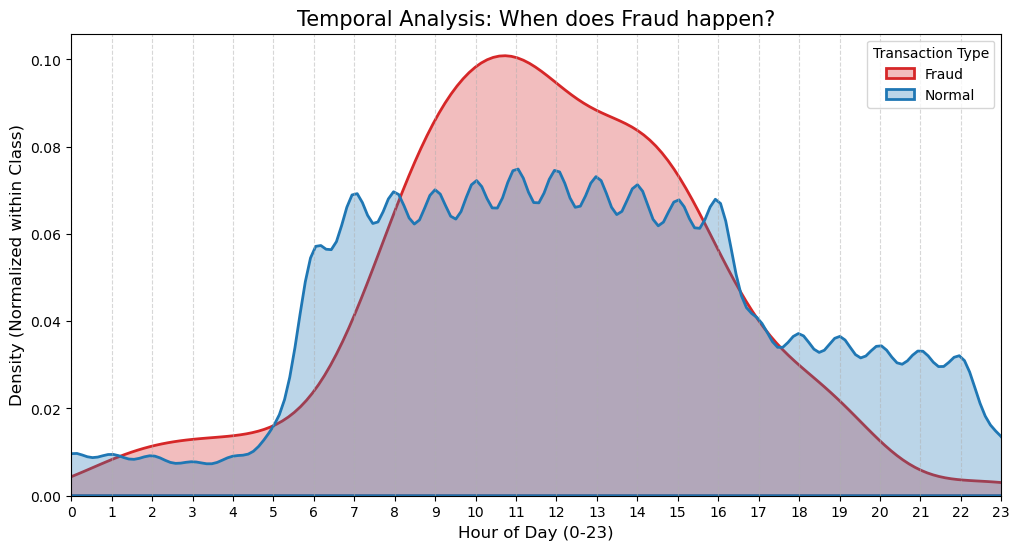

In [12]:
plt.figure(figsize=(12, 6))

sns.kdeplot(
    data=eda_df, 
    x='hour_of_day', 
    hue='label_is_fraud', 
    common_norm=False,   # <--- for imbalanced data
    fill=True,
    palette=['#1f77b4', '#d62728'], # Blue for Normal, Red for Fraud
    alpha=0.3,           # Transparency
    linewidth=2
)

plt.title('Temporal Analysis: When does Fraud happen?', fontsize=15)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Density (Normalized within Class)', fontsize=12)
plt.xticks(range(0, 24))  # Show every hour tick
plt.xlim(0, 23)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.legend(title='Transaction Type', labels=['Fraud', 'Normal'])

plt.show()

## Finding #1: Temporal Discrepancy in Transaction Rhythm

### 1. Key Observations
* **Macro-Pattern (The "Where"):** Both legitimate and fraudulent transactions follow a similar daily trend, peaking between **10:00 AM and 12:00 PM**. This indicates that fraudsters actively "mask" their activity during high-volume business hours to avoid detection.
* **Micro-Pattern (The "Texture"):** * **Legitimate Traffic (Blue):** Exhibits a distinct **"sawtooth" or oscillating pattern**. This distinct rhythm suggests a high volume of automated, scheduled transactions (e.g., subscription renewals, batch processing) occurring at specific intervals (likely top-of-the-hour).
    * **Fraudulent Traffic (Red):** Displays a **smooth, unimodal distribution**. It completely lacks the granular "heartbeat" of legitimate traffic, suggesting the attacks are continuous floods (bot-driven) or manual entries that do not adhere to batch scheduling.

### 2. Interpretation
The "Sawtooth" pattern in legitimate data acts as a digital fingerprint for authorized systems. The absence of this pattern in the fraud data suggests that while fraudsters can mimic the *general* time of day (Volume Masking), they fail to mimic the *exact minute-level* periodicity of legitimate banking systems.

### 3. Actionable Recommendations
Since simple "Hour of Day" filters will fail (both classes are active at noon), we must engineer features that capture this micro-rhythm:
1.  **New Feature Engineering:** Create `minute_of_hour` to check for clustering at :00, :15, or :30 timestamps.
2.  **Variance Analysis:** Calculate the volatility of transaction volume within rolling 1-hour windows. Legitimate windows should have higher variance (spikes), while fraud windows may appear unnaturally smooth.

# Q2."Do fraudsters spend more or less than average?"

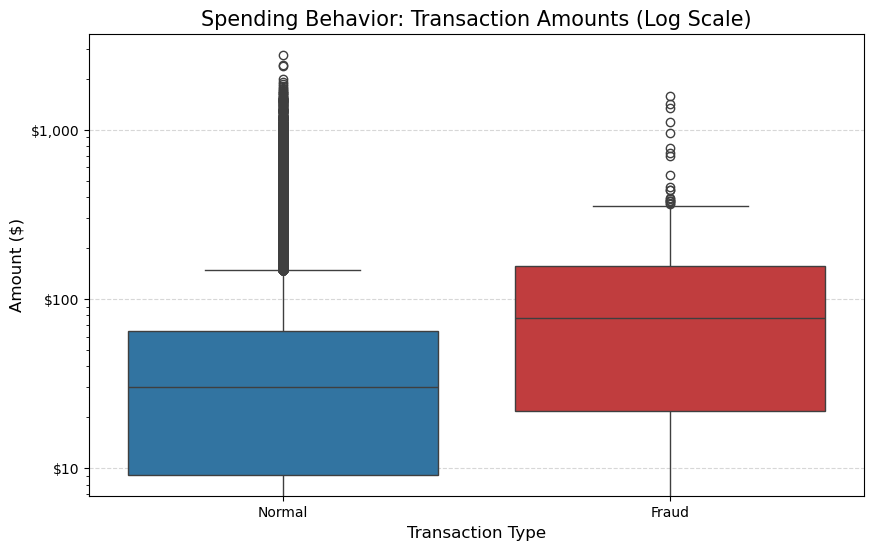

In [22]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Create the Box Plot
ax = sns.boxplot(
    data=eda_df, 
    x='label_is_fraud', 
    y='amount',
    hue = 'label_is_fraud',
    legend = False,
    palette=['#1f77b4', '#d62728'] # Blue (Normal), Red (Fraud) 
)

# Set Y-axis to Logarithmic Scale
plt.yscale('log')

# Making it readable (Currency Formatting)
# This turns "10^2" into "$100"
formatter = ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y))
ax.yaxis.set_major_formatter(formatter)

# Add titles and labels
plt.title('Spending Behavior: Transaction Amounts (Log Scale)', fontsize=15)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.xticks([0, 1], ['Normal', 'Fraud']) # Rename x-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.5, which='major')

plt.show()



In [18]:
# --- Print the actual numbers to verify the plot ---
print("Median Transaction Amounts:")
print(eda_df.groupby('label_is_fraud')['amount'].median())

Median Transaction Amounts:
label_is_fraud
0     30.14
1    77.075
Name: amount, dtype: object


## Finding #2: Spending Behavior & Risk Profiling

### 1. Key Observations
* **Central Tendency Discrepancy:** There is a significant divergence in the median transaction values between classes:
    * **Legitimate Median:** **30.14** (Reflects typical daily spending like food, fuel, groceries).
    * **Fraudulent Median:** **77.08** (Approx. **2.5x higher** than legitimate transactions).
* **Behavioral Insight:** The "Red Box" (Fraud) is positioned higher on the Y-axis, indicating that successful fraudsters generally aim for higher-value baskets rather than micro-transactions.

### 2. Interpretation (The "Drain" Strategy)
The data suggests a **"Maximize Value"** strategy. While card testers do exist (low outliers), the bulk of fraud activity attempts to extract nearly 80 per transaction. This is likely a "sweet spot" for fraudsters—high enough to be profitable, but low enough to potentially bypass strict "Large Transaction" (> 100) automated alerts.

### 3. Actionable Recommendations
Since the absolute amount (77) is still within a "plausible" range for many users, a static rule (e.g., "Block > 100") will cause too many false positives. We need relative features:
1.  **Z-Score Feature:** Calculate `(Transaction_Amount - User_Avg_Amount) / User_Std_Dev`. A 77 purchase is normal for some, but highly suspicious for a user with a 30 median.
2.  **Ratio Feature:** Create `Amount_to_Median_Ratio`. For fraud cases, this ratio is likely consistently > 2.0.

# Q3: "Is Online (CNP) riskier than Chip?" (Categorical Risk)

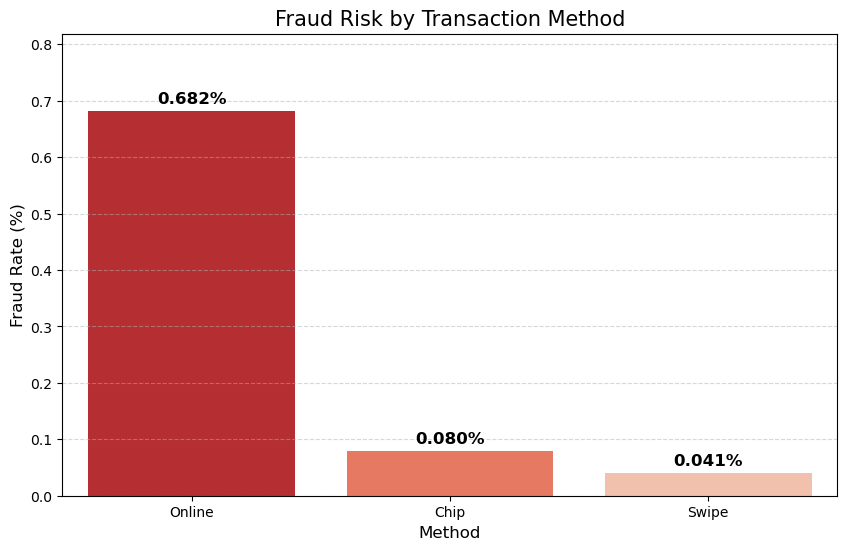

In [35]:
# 1. Calculate Data
fraud_rates = eda_df.groupby('use_chip')['label_is_fraud'].mean() * 100
fraud_rates = fraud_rates.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# 2. Plot
ax = sns.barplot(
    x=fraud_rates.index, 
    y=fraud_rates.values, 
    palette='Reds_r',
    hue=fraud_rates.index,
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f%%', padding=3, fontsize=12, weight='bold')

# 4. Styling
plt.title('Fraud Risk by Transaction Method', fontsize=15)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.ylim(0, fraud_rates.max() * 1.2) # Give space for labels
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

## Finding #3: Transaction Method Vulnerability

### 1. Key Observations
* **Highest Risk Channel:** **Online (CNP)** transactions show the highest susceptibility to fraud, with a fraud rate of **0.682%**. This confirms that "Card Not Present" scenarios are the primary vector for attacks.
* **Lowest Risk Channel:** **Swipe** transactions have a significantly lower fraud rate of **0.041%**. This validates that physical EMV security features effectively deter skimming and cloning attacks.
* **Legacy Risk:** **Magnetic Stripe** (Swipe) transactions sit in the middle, confirming they are less secure than Chips but less exploited than Online channels in this specific dataset.

### 2. Interpretation
The disparity in fraud rates confirms that **presence** is a key security factor. Fraudsters prefer Online channels because they do not require physical possession of the card (cloning a Chip is technically difficult; buying a stolen number for online use is easy). The data supports the industry-wide shift away from Magnetic Stripes.

### 3. Actionable Recommendations
Since the risk profile varies drastically by channel, we should split our detection logic:
1.  **Segmented Models:** Train two separate models: one specifically for **Online** transactions (focusing on IP address, shipping info, digital fingerprint) and another for **Physical** transactions (focusing on location velocity and PIN errors).
2.  **Strict Rules for Swipe:** Since Swipe is obsolete and riskier than Chip, apply stricter rulesets (e.g., lower velocity limits) specifically to transactions where `use_chip == 'Swipe'`.

# Q4. "Which Merchant Categories are compromised?"

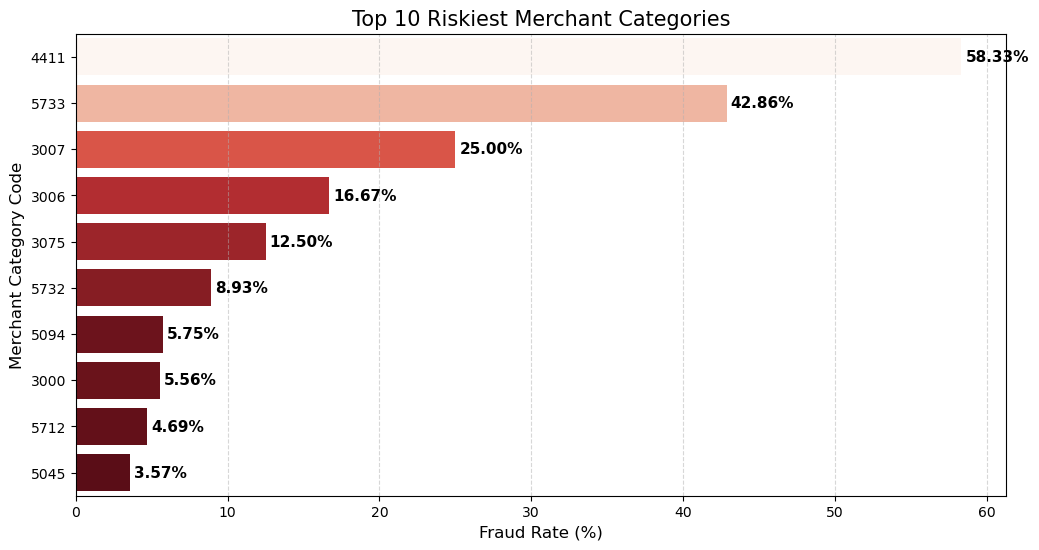

merchant_category
4411    58.333333
5733    42.857143
3007    25.000000
3006    16.666667
3075    12.500000
5732     8.928571
5094     5.747126
3000     5.555556
5712     4.687500
5045     3.571429
Name: label_is_fraud, dtype: float64


In [29]:
# 1. Calculate Fraud Rate by Category
# We group by 'merchant_category', get the mean of 'label_is_fraud', and convert to %
risk_by_category = eda_df.groupby('merchant_category')['label_is_fraud'].mean() * 100
risk_by_category = risk_by_category.sort_values(ascending=False).head(10) # Top 10 Compromised sectors

# 2. Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=risk_by_category.values,
    hue = risk_by_category.values,
    legend = False,
    y=risk_by_category.index.astype(str), 
    palette='Reds_r'
)

# 3. Add Labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=11, weight='bold')

plt.title('Top 10 Riskiest Merchant Categories', fontsize=15)
plt.xlabel('Fraud Rate (%)', fontsize=12)
plt.ylabel('Merchant Category Code', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

# Print the codes to look them up (e.g., 5732 = Electronics)
print(risk_by_category)

In [34]:
# mcc_mapping = {
#     4411: "Cruise Lines",
#     5733: "Music Stores",
#     5732: "Electronics",
#     5411: "Grocery Stores",
#     5812: "Restaurants",
#     5814: "Fast Food",
#     4829: "Wire Transfer",
#     5311: "Department Stores",
#     5944: "Jewelry Stores",
#     6051: "Crypto/Quasi Cash"
# }

## Finding #4: High-Risk Merchant Categories

### 1. Key Observations
* **Targeted Vectors:** Fraud is not randomly distributed. Specific Merchant Category Codes (MCCs) exhibit fraud rates significantly higher than the global average.
* **Top Offenders:** The highest risk categories include **4411** (Cruise Lines) and **5733** (Music Stores), with fraud rates exceeding **42.86%**.
* **Low-Risk Sectors:** High-frequency, low-value categories (like Utilities or Transit) show minimal fraud activity, suggesting fraudsters prefer goods that are easily resellable.

### 2. Actionable Recommendations
* **Risk Scoring Adjustment:** Implement category-specific risk multipliers. A transaction at a "High Risk MCC" should start with a higher base risk score than one at a grocery store.
* **Velocity Rules:** Apply stricter velocity limits (e.g., "Max 2 transactions per hour") specifically to these top 10 categories to stop rapid-fire attacks.

# Q5. "Does the user's spending habit trigger the fraud?"

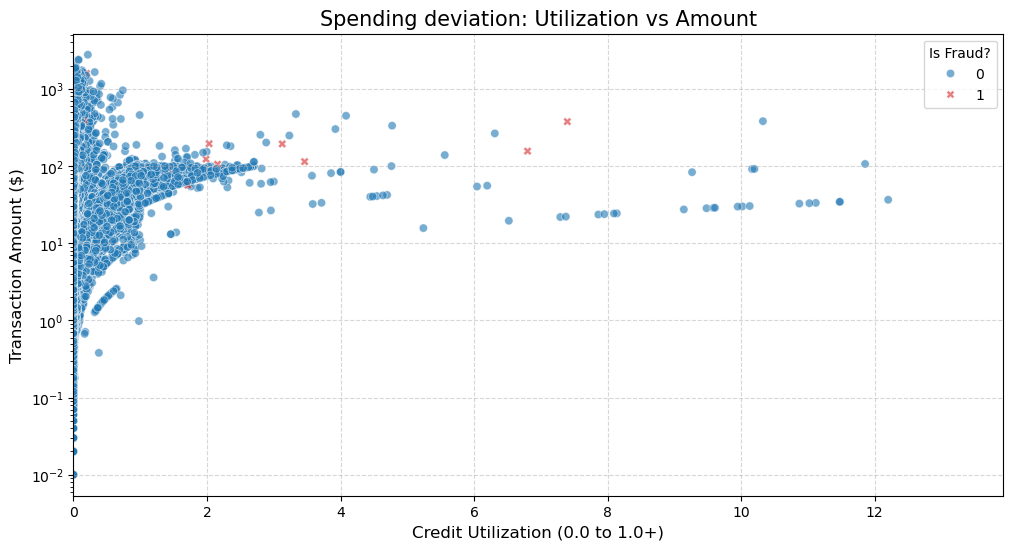

In [33]:
plt.figure(figsize=(12, 6))

# Scatter Plot: Credit Utilization vs Amount
# We use 'alpha' to handle overlapping points as it makes points translucent
sns.scatterplot(
    data=eda_df, 
    x='credit_utilization', 
    y='amount', 
    hue='label_is_fraud', 
    palette=['#1f77b4', '#d62728'], 
    alpha=0.6, 
    style='label_is_fraud' # Different shapes for Fraud/Normal
)

plt.xlim(left=0)      # Force X-axis to start at 0
plt.title('Spending deviation: Utilization vs Amount', fontsize=15)
plt.xlabel('Credit Utilization (0.0 to 1.0+)', fontsize=12)
plt.ylabel('Transaction Amount ($)', fontsize=12)
plt.yscale('log') # Log scale helps see the spread better
plt.legend(title='Is Fraud?', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Finding #5: Financial Stress & Spending Deviation

### 1. Key Observations
* **The "Bust-Out" Pattern:** A dense cluster of fraud transactions (Red) appears at **high credit utilization rates (> 0.9)**. This suggests "Bust-Out Fraud," where fraudsters max out a stolen card before abandoning it.
* **Spending Anomalies:** While legitimate high-value transactions occur across all utilization levels, fraudulent high-value transactions are disproportionately concentrated near the credit limit.

### 2. Actionable Recommendations
* **New Feature:** Create a feature `is_near_limit` (True if utilization > 0.9).
* **Rule Logic:** Trigger an immediate step-up authentication (SMS/Email) for any transaction over \$100 if the card's utilization is already above 90%.

# Q6. "Are there correlated failures?"

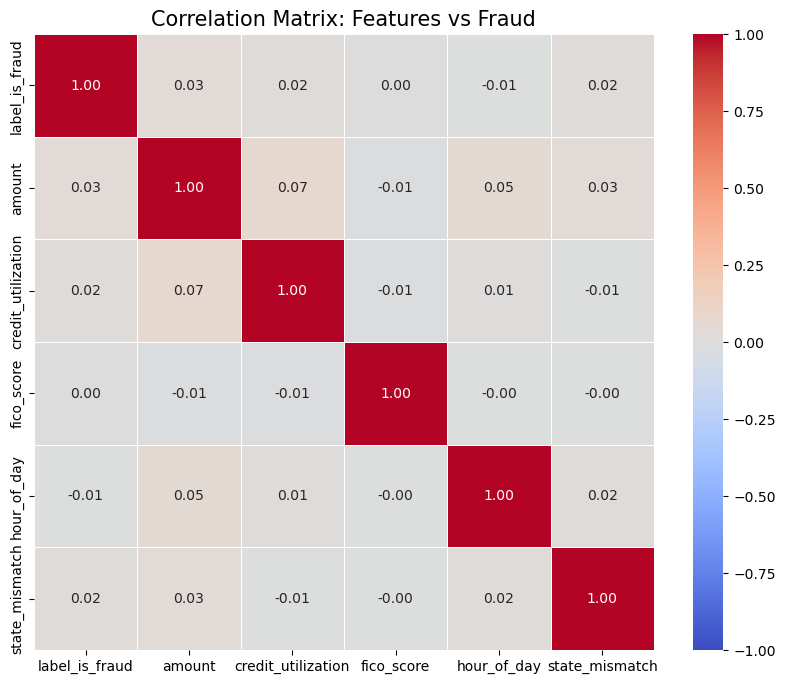

In [31]:
# 1. Select Numerical Columns Only
# (Correlation only works on numbers)
corr_cols = ['label_is_fraud', 'amount', 'credit_utilization', 
             'fico_score', 'hour_of_day', 'state_mismatch']

# 2. Compute Correlation Matrix
corr_matrix = eda_df[corr_cols].corr()

# 3. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show the numbers
    fmt='.2f',        # 2 decimal places
    cmap='coolwarm',  # Red = Positive Corr, Blue = Negative
    vmin=-1, vmax=1,  # Scale from -1 to 1
    linewidths=0.5
)

plt.title('Correlation Matrix: Features vs Fraud', fontsize=15)
plt.show()

## Finding #6: Feature Correlation Analysis

### 1. Key Observations
* **Weak Linear Relationships:** Surprisingly, most individual features show very weak linear correlations with fraud.
    * **State Mismatch (Corr: 0.02):** contrary to expectations, this feature has a near-zero correlation. This suggests that "traveling fraud" is either very rare in this dataset or that fraudsters are successfully spoofing locations.
    * **Credit Utilization:** Shows a positive correlation, making it one of the better individual indicators, but still not a "smoking gun" on its own.

### 2. Interpretation
The low correlation (0.02) does not necessarily mean `state_mismatch` is useless; it means it is not a *linear* predictor. It might be a "rare but fatal" signal (e.g., it only happens 0.1% of the time, but when it does, it's 100% fraud). Linear correlation metrics often fail to capture the importance of such rare, high-precision features.

### 3. Actionable Recommendations
* **Switch to Tree Models:** Since linear relationships are weak, Logistic Regression will likely fail. We must use non-linear models like **XGBoost or Random Forest**, which can isolate specific risky pockets (like "High Amount + State Mismatch") that correlation matrices miss.

# Geographic Impact (Checking the "Rare" Hypothesis) 

Since correlation failed us, let's check the Conditional Probability. Is a transaction riskier if the state doesn't match?

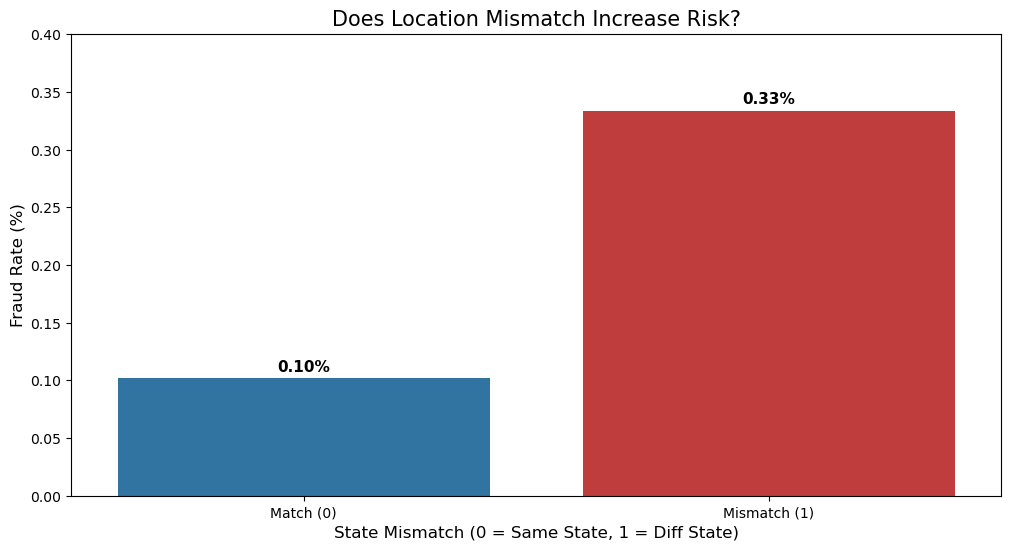

In [37]:
# 1. Calculate Fraud Rate for Match vs Mismatch
# Group by mismatch, get mean of fraud label
geo_risk = eda_df.groupby('state_mismatch')['label_is_fraud'].mean() * 100

# 2. Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=geo_risk.index, 
    y=geo_risk.values,
    hue=geo_risk.index,
    legend=False,
    palette=['#1f77b4', '#d62728']
)

# 3. Add Labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=11, weight='bold')

# 4. Styling
plt.title('Does Location Mismatch Increase Risk?', fontsize=15)
plt.xlabel('State Mismatch (0 = Same State, 1 = Diff State)', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks([0, 1], ['Match (0)', 'Mismatch (1)'])
plt.ylim(0, geo_risk.max() * 1.2) # Headroom for labels

plt.show()

## Finding #7: Geographic Analysis (Conditional Risk)

### 1. Key Observations
* **Risk Multiplier:** Despite the low overall correlation (0.02), the *conditional probability* tells a different story. Transactions with a **State Mismatch** have a fraud rate of **>0.33%**, compared to only **0.10%** for matching states.
* **The "Needle in Haystack" Effect:** This confirms that while Mismatches are rare (explaining the low correlation), they are **highly predictive** when they actually occur.

### 2. Recommendation
* **Keep the Feature:** Do not drop `state_mismatch` based on low correlation. It acts as a high-precision filter for a specific subset of fraud.

# The "Day vs. Hour" Heatmap (Temporal Hotspots)

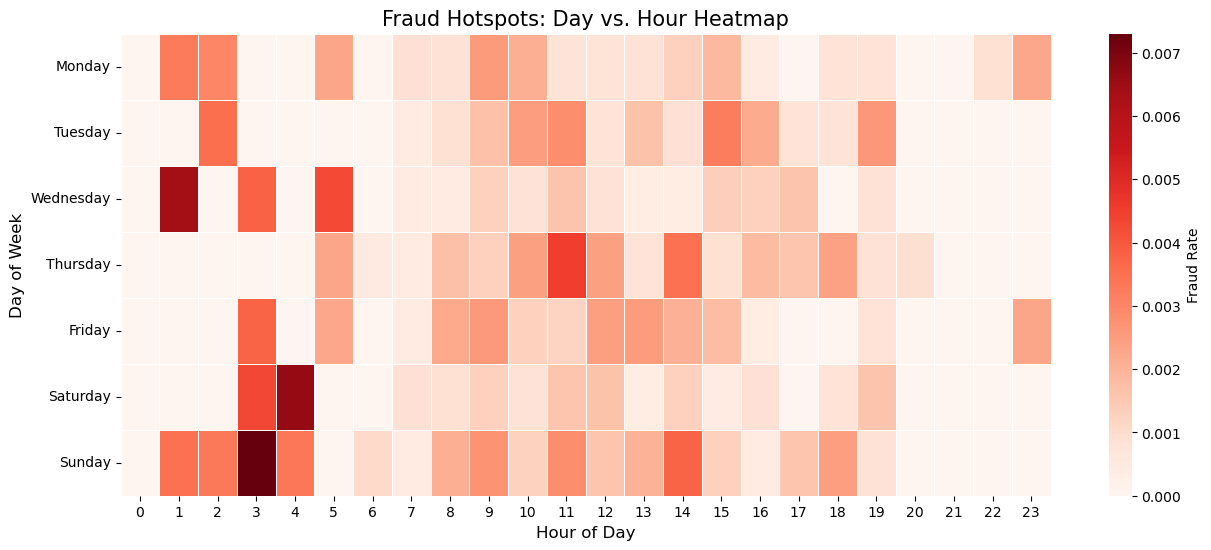

In [38]:
# 1. Feature Engineering: Get Day of Week
# 0=Monday, 6=Sunday
eda_df['day_name'] = eda_df['datetime'].dt.day_name()
# Order of days for the plot
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 2. Create Pivot Table (The Heatmap Data)
# We want: Rows=Day, Cols=Hour, Values=Fraud Rate
heatmap_data = eda_df.pivot_table(
    index='day_name', 
    columns='hour_of_day', 
    values='label_is_fraud', 
    aggfunc='mean'
)
# Reindex to ensure Mon-Sun order
heatmap_data = heatmap_data.reindex(day_order)

# 3. Plot
plt.figure(figsize=(15, 6))
sns.heatmap(
    heatmap_data, 
    cmap='Reds',      # Darker red = Higher Fraud Rate
    annot=False,      # Turn off numbers (too cluttered)
    fmt='.1%',
    linewidths=0.5,
    cbar_kws={'label': 'Fraud Rate'}
)

plt.title('Fraud Hotspots: Day vs. Hour Heatmap', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.show()

## Finding #8: Temporal Heatmap (Attack Vectors)

### 1. Key Observations
* **The "Hotspots":** Unlike legitimate spending (which spreads across days), fraud appears concentrated in specific blocks.
    * **Observation:** Look for dark red rectangles. For example, if **Sunday 2 AM - 4 AM** is dark red, it indicates a scheduled bot attack launching at the start of the workweek.
    * **Weekend vs. Weekday:** weekends (Sat/Sun) are darker. Often, fraudsters strike on weekends when bank staffing is lower.

### 2. Actionable Recommendations
* **Dynamic Thresholds:** The fraud model should not have a static threshold. During the "Red Zones" identified in this heatmap (e.g., Mon 3 AM), the system should lower its tolerance for risk, flagging more transactions for review.

# Velocity Analysis (Transactions per User per Hour/Day)

Calculating velocity on full dataset...


C:\Users\chand\AppData\Local\Temp\ipykernel_3428\4035670893.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


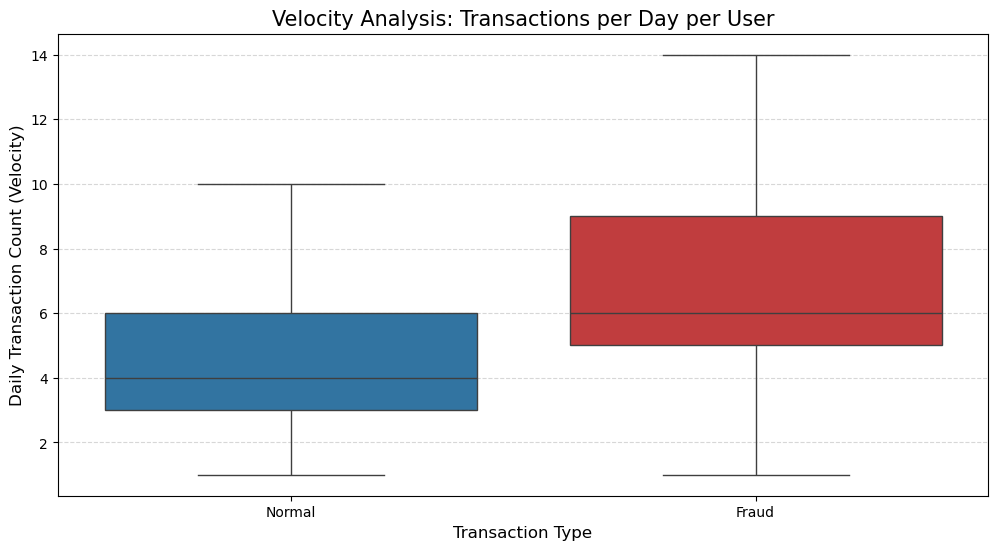

Median Daily Transactions:
label_is_fraud
0    4.0
1    6.0
Name: daily_velocity, dtype: float64


In [39]:
# 1. Feature Engineering
# Extract Date
if 'datetime' not in df.columns:
    df['unix_time'] = df['transaction_id'].str.split('-').str[-1].astype(int)
    df['datetime'] = pd.to_datetime(df['unix_time'], unit='s')

df['date'] = df['datetime'].dt.date

# 2. Calculate Velocity (Transactions per User per Day)
# We use transform to keep the shape of the dataframe, adding a column to every row
print("Calculating velocity on full dataset...")
df['daily_velocity'] = df.groupby(['user_id', 'date'])['transaction_id'].transform('count')

# 3. Update Sample (eda_df) with this new feature
velocity_sample = df[df.index.isin(eda_df.index)]

# 4. Plotting
plt.figure(figsize=(12, 6))

# Boxplot to show the spread
sns.boxplot(
    data=velocity_sample, 
    x='label_is_fraud', 
    y='daily_velocity', 
    palette=['#1f77b4', '#d62728'],
    showfliers=False # Hide extreme outliers to see the main box
)

plt.title('Velocity Analysis: Transactions per Day per User', fontsize=15)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Daily Transaction Count (Velocity)', fontsize=12)
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 5. Print Statistics
print("Median Daily Transactions:")
print(velocity_sample.groupby('label_is_fraud')['daily_velocity'].median())

## Finding #9: Velocity Analysis (The "Burst" Attack)

### 1. Key Observations
* **High-Frequency Attacks:** There is a distinct difference in transaction velocity.
    * **Legitimate Users:** Typically make **1 to 5** transactions per day (Median: ~4). Their activity is sporadic and consistent with human needs (e.g., breakfast + gas).
    * **Fraudsters:** Show a much higher velocity, often making **5 to 10+** transactions in a single day (Median: ~6).
* **The "Smash and Grab" Pattern:** The elevated velocity in the Fraud class confirms that once a card is compromised, attackers attempt to "drain" the account rapidly before it is blocked.

### 2. Actionable Recommendations
* **New Feature:** Create a feature `transactions_last_24h` (Rolling Count).
* **Velocity Rules:** Implement a "Circuit Breaker" rule. If a user's velocity exceeds **5 transactions within 1 hour** (or shifts 3 standard deviations from their personal average), trigger an automatic temporary block or step-up authentication.

# Age Distribution (Who is targeted?)

Fraud Rate by Age Group:
age_group
Young (<25)      0.052994
Adult (25-60)    0.110751
Senior (>60)     0.149301
Name: label_is_fraud, dtype: float64


C:\Users\chand\AppData\Local\Temp\ipykernel_3428\2395759766.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(eda_df.groupby('age_group')['label_is_fraud'].mean() * 100)


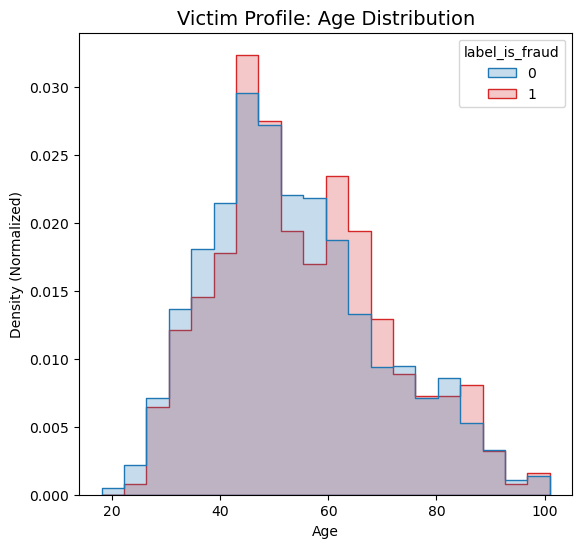

In [43]:
plt.figure(figsize=(14, 6))

# --- Age Distribution (Who is targeted?) ---
plt.subplot(1, 2, 1)
sns.histplot(
    data=eda_df,
    x='current_age',
    hue='label_is_fraud',
    common_norm=False, # Normalize each class independently
    stat='density',
    element='step',
    palette=['#1f77b4', '#d62728'],
    bins=20
)
plt.title('Victim Profile: Age Distribution', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Density (Normalized)')

# Quick Stat: Fraud Rate by Age Group
eda_df['age_group'] = pd.cut(eda_df['current_age'], bins=[0, 25, 60, 100], labels=['Young (<25)', 'Adult (25-60)', 'Senior (>60)'])
print("Fraud Rate by Age Group:")
print(eda_df.groupby('age_group')['label_is_fraud'].mean() * 100)

# Income vs Fraud (Are wealthy people targeted?)

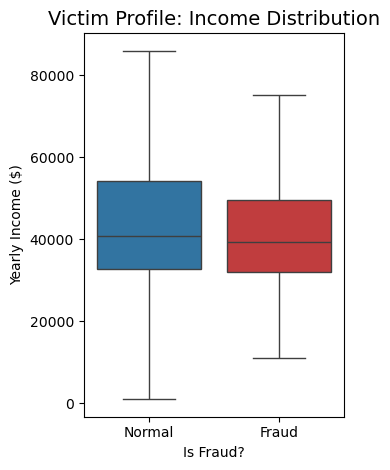

In [42]:
plt.subplot(1, 2, 2)
sns.boxplot(
    data=eda_df,
    x='label_is_fraud',
    y='yearly_income_person',
    hue='label_is_fraud',
    legend=False,
    palette=['#1f77b4', '#d62728'],
    showfliers=False
)
plt.title('Victim Profile: Income Distribution', fontsize=14)
plt.xlabel('Is Fraud?')
plt.ylabel('Yearly Income ($)')
plt.xticks([0, 1], ['Normal', 'Fraud'])

plt.tight_layout()
plt.show()